Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [2]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label=filename.split('_')[-1]
        label=label.split('.')[0]
        label=label.lower()
        labels.append(label)
print("Dataset Successfully Loaded")

Dataset Successfully Loaded


In [3]:
df=pd.DataFrame()
df["speech"]=paths
df["label"]=labels

In [4]:
df.tail()

,speech,label
5595,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5596,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5597,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5598,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5599,/kaggle/input/toronto-emotional-speech-set-tes...,ps


In [5]:
df["label"].value_counts()

label
fear       800
angry      800
disgust    800
neutral    800
sad        800
ps         800
happy      800
Name: count, dtype: int64

# EDA

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

In [7]:
def spectrogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.specshow(xdb,sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

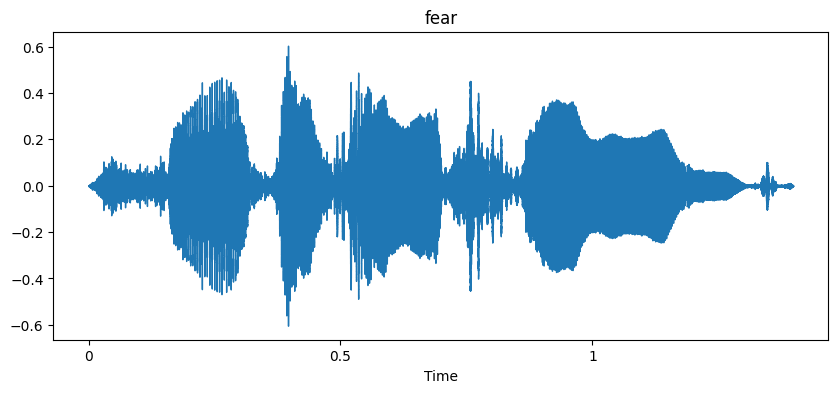

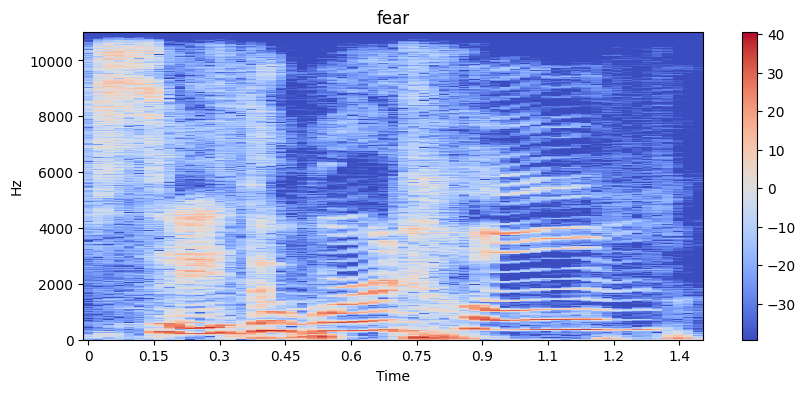

In [8]:
emotion='fear'
path=df['speech'][df['label']==emotion][0]
data, sr= librosa.load(path)
waveplot(data,sr,emotion)
spectrogram(data,sr,emotion)
Audio(path)

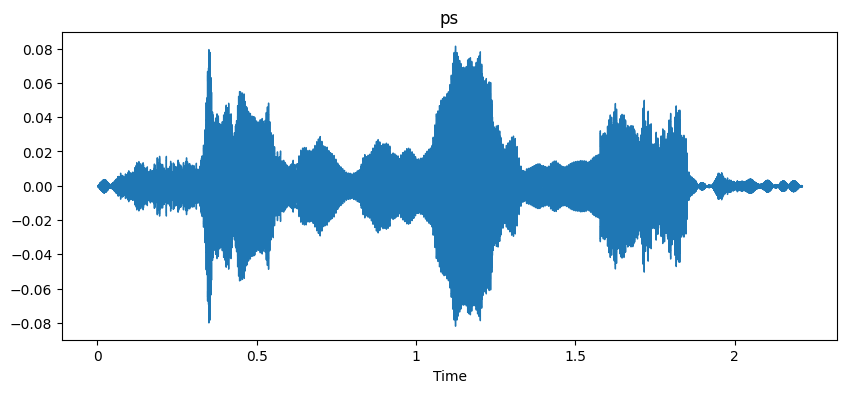

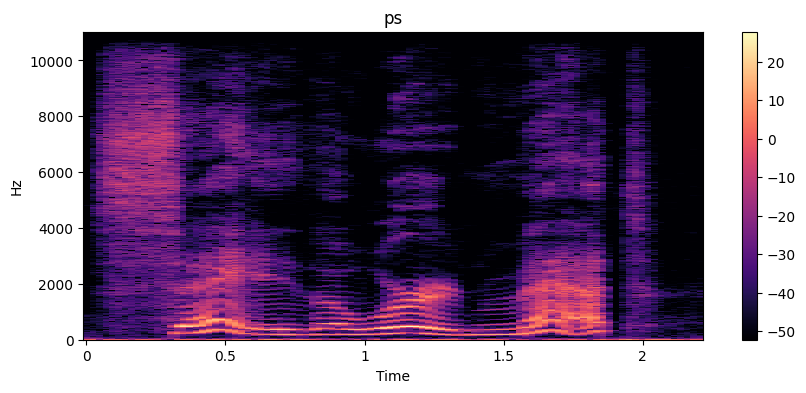

In [9]:
emotion='ps'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sr= librosa.load(path)
waveplot(data,sr,emotion)
spectrogram(data,sr,emotion)
Audio(path)

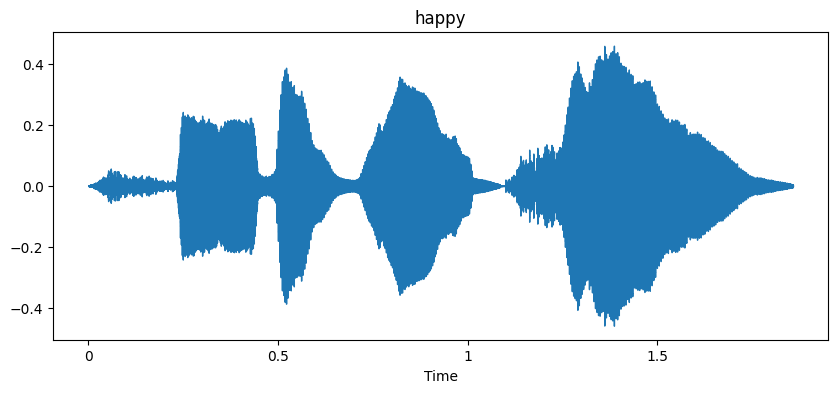

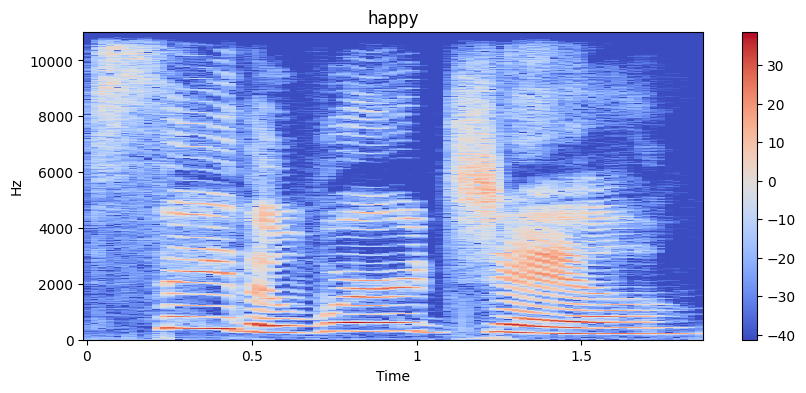

In [10]:
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sr= librosa.load(path)
waveplot(data,sr,emotion)
spectrogram(data,sr,emotion)
Audio(path)

In [11]:
def extract_mfcc(filename):
    y,sr=librosa.load(filename, duration=3, offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [12]:
extract_mfcc(df['speech'][0])

array([-285.73727   ,   85.78295   ,   -2.1689117 ,   22.125532  ,
        -14.757396  ,   11.051346  ,   12.41245   ,   -3.000262  ,
          1.0844991 ,   11.078273  ,  -17.419657  ,   -8.093213  ,
          6.5879726 ,   -4.220953  ,   -9.155081  ,    3.5214806 ,
        -13.186381  ,   14.078853  ,   19.66973   ,   22.725618  ,
         32.574635  ,   16.325033  ,   -3.8427296 ,    0.89629626,
        -11.239264  ,    6.653462  ,   -2.5883694 ,   -7.714016  ,
        -10.941658  ,   -2.4007545 ,   -5.281286  ,    4.271157  ,
        -11.202216  ,   -9.024621  ,   -3.6669843 ,    4.8697433 ,
         -1.602798  ,    2.5600514 ,   11.454374  ,   11.233449  ],
      dtype=float32)

In [14]:
X_mfcc=df['speech'].apply(lambda x: extract_mfcc(x))

In [15]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689117, 22.125532, ...
1       [-348.34332, 35.193233, -3.8413274, 14.658876,...
2       [-340.11435, 53.79644, -14.267782, 20.884027, ...
3       [-306.63422, 21.259705, -4.4110823, 6.487154, ...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
5595    [-374.3952, 60.864998, 0.02505878, 8.431058, -...
5596    [-313.96478, 39.847843, -5.649306, -3.8675754,...
5597    [-357.54883, 77.88606, -15.224756, 2.1946328, ...
5598    [-353.1474, 101.6839, -14.175897, -12.037376, ...
5599    [-389.4595, 54.042767, 1.346998, -1.4258981, -...
Name: speech, Length: 5600, dtype: object

In [17]:
X= [x for x in X_mfcc]
X=np.array(X)
X.shape

(5600, 40)

In [18]:
X=np.expand_dims(X,-1)
X.shape

(5600, 40, 1)

In [20]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y=enc.fit_transform(df[['label']])

In [29]:
y=y.toarray()

In [22]:
y.shape

(5600, 7)

## LSTM Model

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2025-05-17 13:38:34.810053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747489114.997294      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747489115.054251      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [26]:
model=Sequential([
    LSTM(123, return_sequences=False, input_shape=(40,1)),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(7, activation="softmax")
])

I0000 00:00:1747489371.642752      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747489371.643430      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [34]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 123)                 │          61,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,747 (280.26 KB)

 Trainable params: 71,747 (280.26 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history=model.fit(X,y,validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100


I0000 00:00:1747489656.175035     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.2686 - loss: 1.8907 - val_accuracy: 0.1518 - val_loss: 1.9952
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5001 - loss: 1.6267 - val_accuracy: 0.1134 - val_loss: 2.0462
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6130 - loss: 1.2381 - val_accuracy: 0.1286 - val_loss: 1.8510
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6894 - loss: 0.9387 - val_accuracy: 0.2661 - val_loss: 1.5397
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7303 - loss: 0.7581 - val_accuracy: 0.3893 - val_loss: 1.3564
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7741 - loss: 0.6254 - val_accuracy: 0.5286 - val_loss: 1.1830
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8020 - loss: 0.5412 - val_accuracy: 0.6938 - val_loss: 0.8150
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8502 - loss: 0.4154 - val_accuracy: 0.8107 - val_loss: 0.5036
Epoc

In [37]:
model.save("Emotion_Recognizer.h5")

In [38]:
print(os.listdir('.'))

['Emotion_Recognizer.h5', '.virtual_documents']


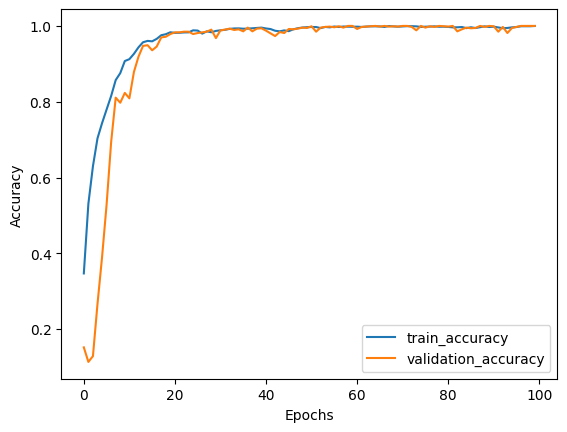

In [41]:
epochs=list(range(100))
acc=history.history["accuracy"]
val_acc=history.history['val_accuracy']
plt.plot(epochs, acc, label="train_accuracy")
plt.plot(epochs,val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()